# AutoEncoder Fusion

This notebook uses AutoEncoder to impute the missing modalities. Take patients MRI data source as an example. We first model MRI->MRI AE to find the latent space for MRI features for those who have MRI records. However, for those who don't, we utilize the UDS->MRI AE to project UDS onto the shared latent space between UDS and MRI. As a result, we can have the complete dataset for MRI. But following issues also need to be considered:
- The AutoEncoder needs a lot hyperparameter tuning. Even though, the latent representation might not be accurate.
- The decoder dimension is high-dimensional (UDS-89, MRI-155). AE might be unstable.
- The distribution of MRI might be different depending on whether a patient has a MRI record or not.

In [1]:
import os, sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from importlib import reload
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import torch
from torch import optim, nn
import torch.utils.data as Data
from torch.nn import functional as F
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def seed_torch(seed=0):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)#as reproducibility docs
    torch.manual_seed(seed)# as reproducibility docs
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False# as reproducibility docs
    torch.backends.cudnn.deterministic = True# as reproducibility docs

In [2]:
target_encoder = LabelEncoder()

def load_data(impute_method = 'Mean-Mode', target = 'NACCAD3'):
    uds = pd.read_csv("../data/data_imputed/{}/uds.csv".format(impute_method))
    uds['datetime'] = pd.to_datetime(uds['datetime'])
    uds = uds.dropna(subset=[target, 'EDUC'])
    
    print("Target Distribution: {}\n".format(Counter(uds[target])))
    uds[target] = target_encoder.fit_transform(uds[target])
    
    mri = pd.read_csv("../data/data_imputed/{}/mri.csv".format(impute_method))
    mri['datetime'] = pd.to_datetime(mri['datetime'])
    
    csf = pd.read_csv("../data/data_imputed/{}/csf.csv".format(impute_method))
    return uds, mri, csf

uds_dict = pd.read_csv("../data/data_dictionary/uds_feature_dictionary_cleaned.csv")
mri_dict = pd.read_csv("../data/data_dictionary/mri_feature_dictionary_cleaned.csv") 

uds_drop_columns = ['NACCID', 'NACCADC', 'NACCVNUM', 'datetime', 'NACCUDSD', 'NACCALZP', 'NACCAD3', 'NACCAD5']
mri_drop_columns = ['NACCID', 'NACCVNUM', 'datetime', 'datetime_UDS', 'timediff', 'within-a-year']
csf_drop_columns = ['NACCID', 'CSFABMD', 'CSFTTMD', 'CSFPTMD']

target = 'NACCAD3'
uds, mri, csf = load_data(target = target)
print(uds.shape, mri.shape, csf.shape)

Target Distribution: Counter({'Healthy': 17673, 'Dementia-AD': 11882, 'MCI-AD': 4470})

(34025, 89) (2873, 161) (2180, 7)


## PCA Transformation

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
scaler = StandardScaler()
pca = None

def pca_transform(df, var_dict, n_component, pca_thres = 0.8):
    global pca
    pca = PCA(n_components=n_component)
    to_ret = pd.DataFrame()
    for cat in var_dict['Category'].unique():
        if cat != 'DEMO':
            var_names = var_dict[var_dict['Category'] == cat]['VariableName'].values
            var_names = set(var_names).intersection(set(df.columns))
            if len(var_names) > n_component:
                pca_transformed = pca.fit_transform(scaler.fit_transform(df.loc[:,var_names]))
                num_selected_1 = np.sum(pca.explained_variance_ratio_ > pca_thres)
                num_selected_2 = np.argmax(-np.diff(pca.explained_variance_ratio_, n=1) > 0.1) + 1
                num_selected = max(num_selected_1, num_selected_2)
                temp = pd.DataFrame(pca_transformed[:,:num_selected])
                temp.columns = ["{}_{}".format(cat, i+1) for i in range(num_selected)]
                print(cat, pca.explained_variance_ratio_, num_selected)
                to_ret = pd.concat([to_ret, temp], axis=1)
    return to_ret

In [4]:
uds_pca = pca_transform(uds.drop(uds_drop_columns, axis=1), uds_dict, 5, pca_thres=0.2)
uds_pca = pd.concat([uds[['NACCID', 'SEX', 'NACCAGE', 'EDUC', 'NACCAPOE', target]].reset_index(drop=True), uds_pca], axis=1)

CDF [0.77679859 0.11136653 0.03487712 0.0303462  0.01334933] 1
GDS [0.31824549 0.07336373 0.06967335 0.05953553 0.05577813] 1
FAS [0.76628492 0.05771446 0.03790491 0.03111185 0.02731422] 1
NPI [0.30070279 0.073176   0.07258526 0.06271501 0.06001287] 1
NEURO [0.34080635 0.12712819 0.08934641 0.0740612  0.04750303] 1


# Clustering on UDS data

In [5]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

In [6]:
def plot_cluster_results(df, index, method = 'tsne'):
    if method == 'tsne':
        m = TSNE(n_components=2, learning_rate='auto', init='random', random_state=0)
    else:
        m = PCA(n_components=2)
    X = pd.DataFrame(m.fit_transform(df.iloc[index].drop(['NACCID', 'NACCAD3', 'label'], axis=1)))
    X['label'] = df.iloc[xti]['label'].values
    for l in X['label'].unique():
        plt.scatter(X[X['label'] == l][0], X[X['label'] == l][1], alpha=0.3, label = l)
    plt.legend()
    plt.show()

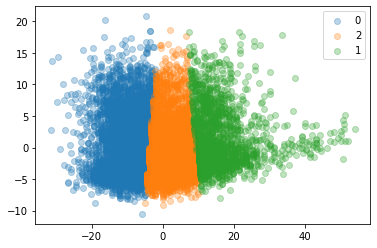

In [7]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(uds_pca.drop(['NACCID', 'NACCAD3'], axis=1))
uds_pca['label'] = kmeans.labels_
xti, xtei = train_test_split(uds_pca.index, train_size = 0.3)
plot_cluster_results(uds_pca, xti, 'pca')

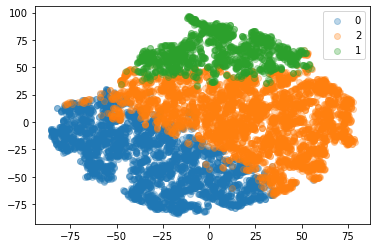

In [8]:
plot_cluster_results(uds_pca, xti, 'tsne')

# MRI

In [9]:
mri_pca = pca_transform(mri.drop(mri_drop_columns, axis=1), mri_dict, 5, pca_thres=0.1)
mri_pca['NACCID'] = mri.reset_index()['NACCID']
mri_pca = mri_pca[mri_pca['NACCID'].isin(uds_pca['NACCID'])]
uds_mri_merged = uds_pca.merge(mri_pca, on='NACCID', how='inner')

Regional gray matter volumes [0.56327925 0.17272831 0.06163145 0.04907454 0.0346227 ] 2
Regional cortical thicknesses [0.44952865 0.05045401 0.03774226 0.03147718 0.02400237] 1
PET scan data [0.37569421 0.12838299 0.07782488 0.0606391  0.02956346] 2


In [10]:
mri_group = mri_pca.merge(uds_pca[['NACCID', 'label']], on='NACCID', how='inner')
mri_info = mri_group.drop(['NACCID'], axis=1).groupby('label').mean().reset_index()
uds_mri_all = uds_pca[~uds_pca['NACCID'].isin(uds_mri_merged['NACCID'])]
uds_mri_all = uds_mri_all.merge(mri_info, on='label')
uds_mri_all = pd.concat([uds_mri_all, uds_mri_merged], axis=0)
print(uds_mri_all.shape)
uds_mri_all.head()

(34025, 17)


,NACCID,SEX,NACCAGE,EDUC,NACCAPOE,NACCAD3,CDF_1,GDS_1,FAS_1,NPI_1,NEURO_1,label,Regional gray matter volumes_1,Regional gray matter volumes_2,Regional cortical thicknesses_1,PET scan data_1,PET scan data_2
0,NACC020208,1,69,16.0,1.0,2,0.634694,-1.006842,0.049701,4.461439,-0.027772,2,0.372871,-0.220863,0.494612,0.545138,-0.130926
1,NACC107305,2,74,18.0,1.0,1,-1.828991,-0.739563,-1.850556,-1.520445,-3.112236,2,0.372871,-0.220863,0.494612,0.545138,-0.130926
2,NACC187327,2,68,14.0,1.0,1,-1.047959,4.032995,-1.850556,-0.879228,-4.368474,2,0.372871,-0.220863,0.494612,0.545138,-0.130926
3,NACC228924,2,70,14.0,1.0,1,-1.828991,-0.158262,-1.850556,-1.520445,-1.323175,2,0.372871,-0.220863,0.494612,0.545138,-0.130926
4,NACC310984,1,72,14.0,1.0,1,-1.828991,-0.088650,-1.850556,-1.520445,0.176919,2,0.372871,-0.220863,0.494612,0.545138,-0.130926


## CSF

In [11]:
csf = csf[csf['NACCID'].isin(uds_pca['NACCID'])]
csf_group = csf.drop(['CSFABMD', 'CSFTTMD', 'CSFPTMD'], axis=1).merge(uds_pca[['NACCID', 'label']], how='inner')
csf_info = csf_group.drop('NACCID', axis=1).groupby('label').mean().reset_index()
uds_mri_csf_merged = uds_mri_all.merge(csf_group.drop('label', axis=1), on='NACCID', how='inner')
uds_mri_csf_all = uds_mri_all[~uds_mri_all['NACCID'].isin(csf_group['NACCID'])]
uds_mri_csf_all = uds_mri_csf_all.merge(csf_info, on='label', how='inner')
uds_mri_csf_all = pd.concat([uds_mri_csf_all, uds_mri_csf_merged], axis=0)
print(uds_mri_csf_all.shape)
uds_mri_csf_all.head()

(34025, 20)


,NACCID,SEX,NACCAGE,EDUC,NACCAPOE,NACCAD3,CDF_1,GDS_1,FAS_1,NPI_1,NEURO_1,label,Regional gray matter volumes_1,Regional gray matter volumes_2,Regional cortical thicknesses_1,PET scan data_1,PET scan data_2,CSFABETA,CSFTTAU,CSFPTAU
0,NACC020208,1,69,16.0,1.0,2,0.634694,-1.006842,0.049701,4.461439,-0.027772,2,0.372871,-0.220863,0.494612,0.545138,-0.130926,598.283618,352.990023,54.928049
1,NACC107305,2,74,18.0,1.0,1,-1.828991,-0.739563,-1.850556,-1.520445,-3.112236,2,0.372871,-0.220863,0.494612,0.545138,-0.130926,598.283618,352.990023,54.928049
2,NACC187327,2,68,14.0,1.0,1,-1.047959,4.032995,-1.850556,-0.879228,-4.368474,2,0.372871,-0.220863,0.494612,0.545138,-0.130926,598.283618,352.990023,54.928049
3,NACC228924,2,70,14.0,1.0,1,-1.828991,-0.158262,-1.850556,-1.520445,-1.323175,2,0.372871,-0.220863,0.494612,0.545138,-0.130926,598.283618,352.990023,54.928049
4,NACC310984,1,72,14.0,1.0,1,-1.828991,-0.088650,-1.850556,-1.520445,0.176919,2,0.372871,-0.220863,0.494612,0.545138,-0.130926,598.283618,352.990023,54.928049


# Prediction Models

In [12]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

def print_summary(clf, Xtr, ytr, Xte, yte, confusion_metrix = False, df_type = None, seed=None):
    if confusion_metrix:
        print(metrics.confusion_matrix(ytr, clf.predict(Xtr)))
        print(metrics.confusion_matrix(yte, clf.predict(Xte)))
    acctr = metrics.accuracy_score(ytr, clf.predict(Xtr))
    auctr = metrics.roc_auc_score(ytr, clf.predict_proba(Xtr), average='macro', multi_class='ovo')
    f1tr_macro = metrics.f1_score(ytr, clf.predict(Xtr), average='macro')
    f1tr_micro = metrics.f1_score(ytr, clf.predict(Xtr), average='micro')
    
    accte = metrics.accuracy_score(yte, clf.predict(Xte))
    aucte = metrics.roc_auc_score(yte, clf.predict_proba(Xte), average='macro', multi_class='ovo')
    f1te_macro = metrics.f1_score(yte, clf.predict(Xte), average='macro')
    f1te_micro = metrics.f1_score(yte, clf.predict(Xte), average='micro')
 
    metrics_df = pd.DataFrame.from_dict({"Train": {"Acc": acctr, "AUC": auctr, "F1-macro": f1tr_macro, "F1-micro": f1tr_micro}, 
                                         "Test": {"Acc": accte, "AUC": aucte, "F1-macro": f1te_macro, "F1-micro": f1te_micro}}, 
                                         orient='Index')
    metrics_df = metrics_df.round(3)
    if df_type is not None:
        metrics_df['Type'] = df_type
    if seed is not None:
        metrics_df['Seed'] = seed
    return metrics_df

def train_logistic(Xtr, ytr, C=0.4, l1_ratio=0.3):
    clf = LogisticRegression(random_state=48, max_iter=1500, solver='saga', penalty='elasticnet', C=C, l1_ratio=l1_ratio)
    clf.fit(Xtr, ytr)
    return clf 

# Inner Join

In [96]:
inner_ppl = set(uds['NACCID']).intersection(mri['NACCID']).intersection(csf['NACCID'])
inner_train_ppl, inner_test_ppl = train_test_split(np.array(list(inner_ppl)), test_size = 0.2, random_state=48)
inner_train = uds_mri_csf_all[uds_mri_csf_all['NACCID'].isin(inner_train_ppl)]
inner_test = uds_mri_csf_all[uds_mri_csf_all['NACCID'].isin(inner_test_ppl)]
Xi_train, yi_train = inner_train.drop(['NACCID', target], axis=1), inner_train[target]
Xi_test, yi_test = inner_test.drop(['NACCID', 'NACCAD3'], axis=1), inner_test['NACCAD3']

print("Number of people have all three modalities:  ", len(inner_ppl))
print("Train: {}\tTest: {}".format(inner_train_ppl.shape[0], inner_test_ppl.shape[0]))

clf_inner = train_logistic(Xi_train, yi_train)
print_summary(clf_inner, Xi_train, yi_train, Xi_test, yi_test)

# scaler_inner = StandardScaler()
# clf_inner = train_logistic(scaler_inner.fit_transform(Xi_train), yi_train)
# print_summary(clf_inner, scaler_inner.transform(Xi_train), yi_train, scaler_inner.transform(Xi_test), yi_test)

Number of people have all three modalities:   264
Train: 211	Test: 53


,Acc,AUC,F1-macro,F1-micro
Train,0.863,0.866,0.679,0.863
Test,0.792,0.738,0.518,0.792


## Group Information

In [97]:
outer_ppl = list(set(uds_mri_csf_all['NACCID'])- inner_ppl)
outer_train_ppl, outer_test_ppl = train_test_split(np.array(outer_ppl), test_size = 0.2, random_state=48)
outer_train_ppl = np.concatenate([outer_train_ppl, inner_train_ppl])
outer_test_ppl = np.concatenate([outer_test_ppl, inner_test_ppl])
outer_train = uds_mri_csf_all[uds_mri_csf_all['NACCID'].isin(outer_train_ppl)]
outer_test = uds_mri_csf_all[uds_mri_csf_all['NACCID'].isin(outer_test_ppl)]
Xo_train, yo_train = outer_train.drop(['NACCID', target], axis=1), outer_train[target]
Xo_test, yo_test = outer_test.drop(['NACCID', target], axis=1), outer_test['NACCAD3']

print("Number of people do NOT have all three modalities:  ", len(outer_ppl))
print("Train: {}\tTest: {}".format(outer_train.shape[0], outer_test.shape[0]))

clf_group = train_logistic(Xo_train, yo_train)
print_summary(clf_group, Xo_train, yo_train, Xo_test, yo_test)

# scaler_group = StandardScaler()
# clf_group = train_logistic(scaler_group.fit_transform(Xo_train), yo_train)
# print_summary(clf_group, scaler_group.transform(Xo_train), yo_train, scaler_group.transform(Xo_test), yo_test)

Number of people do NOT have all three modalities:   33761
Train: 27219	Test: 6806


,Acc,AUC,F1-macro,F1-micro
Train,0.855,0.927,0.684,0.855
Test,0.859,0.931,0.688,0.859


In [98]:
# Inner model performance on the outer people
display(print_summary(clf_inner, scaler_inner.transform(Xo_train), yo_train, scaler_inner.transform(Xo_test), yo_test))

# Outer model performance on the inner people
display(print_summary(clf_group, scaler_group.transform(Xi_train), yi_train, scaler_group.transform(Xi_test), yi_test))

,Acc,AUC,F1-macro,F1-micro
Train,0.729,0.827,0.553,0.729
Test,0.732,0.827,0.556,0.732


,Acc,AUC,F1-macro,F1-micro
Train,0.891,0.928,0.737,0.891
Test,0.887,0.826,0.607,0.887


## Auto-Encoder

In [21]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, e_dim, d_dim, seed=48):
        super(AutoEncoder, self).__init__()
        seed_torch(seed)
        e_list = [nn.Linear(e_dim[0], e_dim[1])]
        for i in range(2, len(e_dim)):
            e_list.append(nn.ReLU())
#             e_list.append(nn.Dropout(0.1))
            e_list.append(nn.Linear(e_dim[i-1], e_dim[i]))
        d_list = [nn.Linear(d_dim[0], d_dim[1])]
        for i in range(2, len(d_dim)):
            d_list.append(nn.ReLU())
#             d_list.append(nn.Dropout(0.1))
            d_list.append(nn.Linear(d_dim[i-1], d_dim[i]))
        self.encoder_layers = nn.Sequential(*e_list)
        self.decoder_layers = nn.Sequential(*d_list)
    def encode(self, X):
        return self.encoder_layers(X)
    def decode(self, Z):
        return self.decoder_layers(Z)
    def loss(self, X1, X2):
        Z = self.encoder_layers(X1)
        X_hat = self.decoder_layers(Z)
        return torch.mean((X2-X_hat)**2)
    
def prepare_autoencoder_data(ppl_list, original=True, U_scaler=None, M_scaler=None, C_scaler=None):
    if original:
        U = uds[uds['NACCID'].isin(ppl_list)][['NACCID', 'NACCAD3'] + Ucol]
    else:
        U = uds_pca[uds_pca['NACCID'].isin(ppl_list)].drop('label', axis=1)
    if U_scaler is None:
        U_scaler = StandardScaler()
        U[Ucol] = U_scaler.fit_transform(U[Ucol])
    else:
        U[Ucol] = U_scaler.transform(U[Ucol])
    Utr = torch.tensor(U[Ucol].to_numpy()).float().to(device)
 
    if original:
        M = mri[mri['NACCID'].isin(ppl_list)][['NACCID'] + Mcol]
    else:
        M = mri_pca[mri_pca['NACCID'].isin(ppl_list)]
    if M_scaler is None:
        M_scaler = StandardScaler()
        M[Mcol] = M_scaler.fit_transform(M[Mcol])
    else:
         M[Mcol] = M_scaler.transform(M[Mcol])
    Mtr = torch.tensor(M[Mcol].to_numpy()).float().to(device)

    C = csf[csf['NACCID'].isin(ppl_list)][['NACCID'] + Ccol]
    if C_scaler is None:
        C_scaler = StandardScaler()
        C[Ccol] = C_scaler.fit_transform(C[Ccol])
    else:
        C[Ccol] = C_scaler.transform(C[Ccol])
        
    abc_ppl = np.array(list(set(U['NACCID']).intersection(M['NACCID']).intersection(C['NACCID'])))
    ab_ppl = np.array(list(set(U['NACCID']).intersection(M['NACCID']) - set(abc_ppl)))
    ac_ppl = np.array(list(set(U['NACCID']).intersection(C['NACCID']) - set(abc_ppl)))
    a_ppl = np.array(list(set(U['NACCID']) - set(mri['NACCID']) - set(C['NACCID'])))
    assert(len(abc_ppl) + len(ab_ppl) + len(ac_ppl) + len(a_ppl) == len(U))
    
    abc = U[U['NACCID'].isin(abc_ppl)].merge(M[M['NACCID'].isin(abc_ppl)], on='NACCID')\
                                  .merge(C[C['NACCID'].isin(abc_ppl)][['NACCID'] + Ccol], on='NACCID').drop(['NACCID'], axis=1)
    ab = U[U['NACCID'].isin(ab_ppl)].merge(M[M['NACCID'].isin(ab_ppl)], on='NACCID').drop(['NACCID'], axis=1)
    ac = U[U['NACCID'].isin(ac_ppl)].merge(C[C['NACCID'].isin(ac_ppl)][['NACCID'] + Ccol] , on='NACCID').drop(['NACCID'], axis=1)
    a = U[U['NACCID'].isin(a_ppl)].drop(['NACCID'], axis=1)
    y = torch.tensor(np.concatenate([abc[target].values, ab[target].values, ac[target].values, a[target].values])).float().to(device)

    abc = torch.tensor(abc.drop(target, axis=1).to_numpy()).float().to(device)
    ab = torch.tensor(ab.drop(target, axis=1).to_numpy()).float().to(device)
    ac = torch.tensor(ac.drop(target, axis=1).to_numpy()).float().to(device)
    a = torch.tensor(a.drop(target, axis=1).to_numpy()).float().to(device)
    
    return abc, ab, ac, a, y, Utr, Mtr, U_scaler, M_scaler, C_scaler

In [100]:
original = True

if original:
    Ucol, Mcol, Ccol = list(uds.drop(uds_drop_columns, axis=1).columns), \
                   list(mri.drop(mri_drop_columns, axis=1).columns), \
                   ['CSFABETA', 'CSFTTAU', 'CSFPTAU'] 
else:
    Ucol, Mcol, Ccol = list(uds_pca.drop(["NACCID", 'label', target], axis=1).columns), \
                   list(mri_pca.drop(['NACCID'], axis=1).columns), \
                   ['CSFABETA', 'CSFTTAU', 'CSFPTAU']
    
abc, ab, ac, a, y, Utr, Mtr, U_scaler, M_scaler, C_scaler = prepare_autoencoder_data(outer_train_ppl, original)
abcte, abte, acte, ate, yte, Ute, Mte, U_scaler, M_scaler, C_scaler = prepare_autoencoder_data(outer_test_ppl, original, U_scaler, M_scaler, C_scaler)


## U Encoder

In [27]:
def train_Uenc(U_enc, U_dec, Utr, display_intvl=50):
    U_enc = AutoEncoder(U_enc, U_dec).to(device)
    optimizer = torch.optim.Adam(U_enc.parameters(), lr=1e-4, weight_decay=1e-5)
    U_enc_loss = U_enc.loss(Utr, Utr)
    last_loss, loss = 0, 0
    for epoch in range(5000):
        loss =  U_enc.loss(Utr, Utr)
        loss.backward()
        optimizer.step()
        if (epoch % display_intvl == 0 or torch.abs(last_loss - loss) < 1e-9):
            print('U-Enc Epoch {}:  Loss: {:.3f}'.format(epoch, loss.item()))
        if torch.abs(last_loss - loss) < 1e-9:
            break
        last_loss = loss
    return U_enc

In [102]:
print(Utr.shape)

torch.Size([27219, 81])


In [103]:
U_enc = train_Uenc([81, 64, 16], [16, 32, 81], Utr)
print("U Enc Test:  {:.3f}".format(U_enc.loss(Ute, Ute).item()))

Epoch 0:  Loss: 1.017
Epoch 50:  Loss: 0.987
Epoch 100:  Loss: 0.929
Epoch 150:  Loss: 0.858
Epoch 200:  Loss: 0.813
Epoch 250:  Loss: 0.767
Epoch 300:  Loss: 0.738
Epoch 350:  Loss: 0.715
Epoch 400:  Loss: 0.695
Epoch 450:  Loss: 0.678
Epoch 500:  Loss: 0.672
Epoch 550:  Loss: 0.653
Epoch 600:  Loss: 0.651
Epoch 650:  Loss: 0.637
Epoch 700:  Loss: 0.636
Epoch 750:  Loss: 0.628
Epoch 800:  Loss: 0.619
Epoch 850:  Loss: 0.616
Epoch 900:  Loss: 0.625
Epoch 950:  Loss: 0.594
Epoch 1000:  Loss: 0.618
Epoch 1050:  Loss: 0.587
Epoch 1100:  Loss: 0.597
Epoch 1150:  Loss: 0.609
Epoch 1200:  Loss: 0.592
Epoch 1250:  Loss: 0.578
Epoch 1300:  Loss: 0.597
Epoch 1350:  Loss: 0.565
Epoch 1400:  Loss: 0.584
Epoch 1450:  Loss: 0.588
Epoch 1500:  Loss: 0.581
Epoch 1550:  Loss: 0.576
Epoch 1600:  Loss: 0.565
Epoch 1650:  Loss: 0.557
Epoch 1700:  Loss: 0.562
Epoch 1750:  Loss: 0.555
Epoch 1800:  Loss: 0.552
Epoch 1850:  Loss: 0.555
Epoch 1900:  Loss: 0.557
Epoch 1950:  Loss: 0.551
Epoch 2000:  Loss: 0.54

## M-Enc

In [26]:
def train_Menc(M_enc, M_dec, Mtr, display_intvl=50):
    M_enc = AutoEncoder(M_enc, M_dec).to(device)
    optimizer = torch.optim.Adam(M_enc.parameters(), lr=1e-4, weight_decay=1e-5)
    last_loss, loss = 0, 0
    for epoch in range(5000):
        loss =  M_enc.loss(Mtr, Mtr)
        loss.backward()
        optimizer.step()
        if (epoch % display_intvl == 0 or torch.abs(last_loss - loss) < 1e-9):
            print('M-Enc Epoch {}:  Loss: {:.3f}'.format(epoch, loss.item()))
        if torch.abs(last_loss - loss) < 1e-9:
            break
        last_loss = loss
    return M_enc

In [105]:
M_enc = train_Menc([155, 64, 16, 8], [8, 16, 64, 155], Mtr)

Epoch 0:  Loss: 1.009
Epoch 50:  Loss: 1.001
Epoch 100:  Loss: 0.980
Epoch 150:  Loss: 0.896
Epoch 200:  Loss: 0.789
Epoch 250:  Loss: 0.752
Epoch 300:  Loss: 0.705
Epoch 350:  Loss: 0.728
Epoch 400:  Loss: 0.697
Epoch 450:  Loss: 0.733
Epoch 500:  Loss: 0.674
Epoch 550:  Loss: 0.682
Epoch 600:  Loss: 0.659
Epoch 650:  Loss: 0.634
Epoch 700:  Loss: 0.651
Epoch 750:  Loss: 0.612
Epoch 800:  Loss: 0.626
Epoch 850:  Loss: 0.573
Epoch 900:  Loss: 0.608
Epoch 950:  Loss: 0.644
Epoch 1000:  Loss: 0.617
Epoch 1050:  Loss: 0.591
Epoch 1100:  Loss: 0.586
Epoch 1150:  Loss: 0.595
Epoch 1200:  Loss: 0.564
Epoch 1250:  Loss: 0.586
Epoch 1300:  Loss: 0.580
Epoch 1350:  Loss: 0.581
Epoch 1400:  Loss: 0.570
Epoch 1450:  Loss: 0.587
Epoch 1500:  Loss: 0.574
Epoch 1550:  Loss: 0.590
Epoch 1600:  Loss: 0.590
Epoch 1650:  Loss: 0.560
Epoch 1700:  Loss: 0.574
Epoch 1750:  Loss: 0.583
Epoch 1800:  Loss: 0.578
Epoch 1850:  Loss: 0.551
Epoch 1900:  Loss: 0.552
Epoch 1950:  Loss: 0.570
Epoch 2000:  Loss: 0.56

# UM-Enc

In [31]:
def train_UMenc(UM_enc, UM_dec, ab, display_intvl=50):
    UM_enc = AutoEncoder(UM_enc, UM_dec).to(device)
    optimizer = torch.optim.Adam(UM_enc.parameters(), lr=1e-3, weight_decay=1e-5)
    last_loss, loss = 0, 0
    for epoch in range(5000):
        UM_enc_loss = UM_enc.loss(ab[:,:len(Ucol)], ab[:,len(Ucol):]) 
        UM_overlap_loss = torch.mean((UM_enc.encode(ab[:,:len(Ucol)]) - M_enc.encode(ab[:,len(Ucol):]))**2)
        loss =  UM_enc_loss + UM_overlap_loss
        loss.backward()
        optimizer.step()
        if (epoch % display_intvl == 0 or torch.abs(last_loss - loss) < 1e-9):
            print('UM-ENC Epoch {}:  Loss: {:.3f}'.format(epoch, loss.item()))
        if torch.abs(last_loss - loss) < 1e-9:
            break
        last_loss = loss
    return UM_enc

In [121]:
UM_enc = train_UMenc([81, 32, 16, 8], [8, 16, 64, 155], ab)

Epoch 0:  Loss: 148.380
Epoch 50:  Loss: 131.500
Epoch 100:  Loss: 105.474
Epoch 150:  Loss: 87.051
Epoch 200:  Loss: 114.098
Epoch 250:  Loss: 96.361
Epoch 300:  Loss: 96.515
Epoch 350:  Loss: 91.501
Epoch 400:  Loss: 91.720
Epoch 450:  Loss: 82.965
Epoch 500:  Loss: 76.057
Epoch 550:  Loss: 74.868
Epoch 600:  Loss: 72.123
Epoch 650:  Loss: 82.714
Epoch 700:  Loss: 72.224
Epoch 750:  Loss: 84.327
Epoch 800:  Loss: 75.351
Epoch 850:  Loss: 82.209
Epoch 900:  Loss: 75.568
Epoch 950:  Loss: 89.909
Epoch 1000:  Loss: 80.881
Epoch 1050:  Loss: 84.077
Epoch 1100:  Loss: 87.163
Epoch 1150:  Loss: 75.462
Epoch 1200:  Loss: 89.650
Epoch 1250:  Loss: 94.077
Epoch 1300:  Loss: 89.626
Epoch 1350:  Loss: 80.566
Epoch 1400:  Loss: 79.798
Epoch 1450:  Loss: 88.920
Epoch 1500:  Loss: 77.527
Epoch 1550:  Loss: 71.509
Epoch 1600:  Loss: 78.680
Epoch 1650:  Loss: 84.075
Epoch 1700:  Loss: 84.451
Epoch 1750:  Loss: 80.574
Epoch 1800:  Loss: 76.792
Epoch 1850:  Loss: 79.620
Epoch 1900:  Loss: 84.967
Epoch

KeyboardInterrupt: 

## M + UM Encoder

In [68]:
def train_Menc(M_enc, M_dec, UM_enc, UM_dec, Mtr, Utr):
    M_enc = AutoEncoder(M_enc, M_dec).to(device)
    UM_enc = AutoEncoder(UM_enc, UM_dec).to(device)

    params = list(UM_enc.parameters()) + list(M_enc.parameters())
    optimizer = torch.optim.Adam(params, lr=1e-4, weight_decay=1e-5)
  
    last_loss, loss = 0, 0
    for epoch in range(5000):
        M_enc_loss = M_enc.loss(Mtr, Mtr) # Project M to M, autoencoder loss
        UM_enc_loss = UM_enc.loss(ab[:,:len(Ucol)], ab[:,len(Ucol):]) # Project U to M, autoencoder loss
        UM_overlap_loss = torch.mean((UM_enc.encode(ab[:,:len(Ucol)]) - M_enc.encode(ab[:,len(Ucol):]))**2) # UM and M shared latent space loss
        loss =  M_enc_loss + UM_enc_loss + UM_overlap_loss
        loss.backward()
        optimizer.step()
        if (epoch % 50 == 0 or torch.abs(last_loss - loss) < 1e-9):
            print('Epoch {}:  Loss: {:.3f} UM: {:.3f} M:{:.3f} UMO: {:.3f}'.format(
                epoch, loss.item(), M_enc_loss.item(), UM_enc_loss.item(), UM_overlap_loss.item()))
        if torch.abs(last_loss - loss) < 1e-9:
            break
        last_loss = loss
    return M_enc, UM_enc

In [69]:
print(Mtr.shape)

torch.Size([1859, 155])


In [70]:
M_enc, UM_enc = train_Menc([155, 64, 16], [16, 128, 155], [81, 64, 16], [16, 128, 155], Mtr, Utr)
# M_enc, UM_enc = train_Menc([5, 3], [3, 5], [9, 3], [3, 5], Mtr, Utr)

M_enc_loss = M_enc.loss(Mte, Mte) # Project M to M, autoencoder loss
UM_enc_loss = UM_enc.loss(abte[:,:len(Ucol)], abte[:,len(Ucol):]) # Project U to M, autoencoder loss
UM_overlap_loss = torch.mean((UM_enc.encode(abte[:,:len(Ucol)]) - M_enc.encode(abte[:,len(Ucol):]))**2) # UM and M shared latent space loss

print('UM: {:.3f} M:{:.3f} UMO: {:.3f}'.format(M_enc_loss.item(), UM_enc_loss.item(), UM_overlap_loss.item()))

Epoch 0:  Loss: 2.143 UM: 1.005 M:1.026 UMO: 0.112
Epoch 50:  Loss: 2.046 UM: 0.986 M:1.017 UMO: 0.043
Epoch 100:  Loss: 1.983 UM: 0.901 M:1.009 UMO: 0.073
Epoch 150:  Loss: 1.843 UM: 0.745 M:0.978 UMO: 0.119
Epoch 200:  Loss: 1.720 UM: 0.688 M:0.925 UMO: 0.108
Epoch 250:  Loss: 1.690 UM: 0.663 M:0.894 UMO: 0.134
Epoch 300:  Loss: 1.707 UM: 0.742 M:0.875 UMO: 0.090
Epoch 350:  Loss: 1.643 UM: 0.642 M:0.860 UMO: 0.141
Epoch 400:  Loss: 1.528 UM: 0.595 M:0.844 UMO: 0.089
Epoch 450:  Loss: 1.645 UM: 0.703 M:0.839 UMO: 0.104
Epoch 500:  Loss: 1.816 UM: 0.750 M:0.877 UMO: 0.189
Epoch 550:  Loss: 1.823 UM: 0.702 M:0.903 UMO: 0.217
Epoch 600:  Loss: 2.121 UM: 1.030 M:0.867 UMO: 0.223
Epoch 650:  Loss: 1.770 UM: 0.728 M:0.868 UMO: 0.174
Epoch 700:  Loss: 1.947 UM: 0.731 M:0.872 UMO: 0.344
Epoch 750:  Loss: 1.826 UM: 0.706 M:0.863 UMO: 0.258
Epoch 800:  Loss: 1.964 UM: 0.775 M:0.915 UMO: 0.274
Epoch 850:  Loss: 1.867 UM: 0.731 M:0.857 UMO: 0.279
Epoch 900:  Loss: 2.105 UM: 0.934 M:0.900 UMO: 0.

## UC Encoder

In [32]:
def train_UCenc(enc_dim, dec_dim, ac, display_intvl=50):
    UC_enc = AutoEncoder(enc_dim, dec_dim).to(device)
    optimizer = torch.optim.Adam(UC_enc.parameters(), lr=1e-4, weight_decay=1e-5)
    last_loss, loss = 0, 0
    for epoch in range(5000):
        loss = UC_enc.loss(ac[:,:len(Ucol)], ac[:,len(Ucol):]) # Project M to M, autoencoder loss
        loss.backward()
        optimizer.step()
        if (epoch % display_intvl == 0 or torch.abs(last_loss - loss) < 1e-9):
            print('UC-Enc Epoch {}:  Loss: {:.3f}'.format(
                epoch, loss.item()))
        if torch.abs(last_loss - loss) < 1e-9:
            break
        last_loss = loss
    return UC_enc

In [109]:
UC_enc = train_UCenc([81, 32, 8, 3], [3, 3], ac)
# UC_enc = train_UCenc([9, 5, 2], [2, 3], ac)
print("UC Test Loss: {:.3f}".format(UC_enc.loss(acte[:,:len(Ucol)], acte[:,len(Ucol):])))

Epoch 0:  Loss: 1.253
Epoch 50:  Loss: 1.205
Epoch 100:  Loss: 1.152
Epoch 150:  Loss: 1.093
Epoch 200:  Loss: 1.033
Epoch 250:  Loss: 0.991
Epoch 300:  Loss: 0.984
Epoch 350:  Loss: 0.985
Epoch 400:  Loss: 0.947
Epoch 450:  Loss: 0.897
Epoch 500:  Loss: 0.869
Epoch 550:  Loss: 0.854
Epoch 600:  Loss: 0.844
Epoch 650:  Loss: 0.834
Epoch 700:  Loss: 0.827
Epoch 750:  Loss: 0.821
Epoch 800:  Loss: 0.815
Epoch 850:  Loss: 0.806
Epoch 900:  Loss: 0.796
Epoch 950:  Loss: 0.784
Epoch 1000:  Loss: 0.772
Epoch 1050:  Loss: 0.763
Epoch 1100:  Loss: 0.757
Epoch 1150:  Loss: 0.750
Epoch 1200:  Loss: 0.741
Epoch 1250:  Loss: 0.735
Epoch 1300:  Loss: 0.729
Epoch 1350:  Loss: 0.724
Epoch 1400:  Loss: 0.718
Epoch 1450:  Loss: 0.713
Epoch 1500:  Loss: 0.705
Epoch 1550:  Loss: 0.695
Epoch 1600:  Loss: 0.689
Epoch 1650:  Loss: 0.684
Epoch 1700:  Loss: 0.677
Epoch 1750:  Loss: 0.671
Epoch 1800:  Loss: 0.670
Epoch 1850:  Loss: 0.666
Epoch 1900:  Loss: 0.657
Epoch 1950:  Loss: 0.654
Epoch 2000:  Loss: 0.65

## Train Losgistic On Latent Features

In [18]:
def construct_latent(abc, ab, ac, a):
    Habc = torch.concat([U_enc.encode(abc[:,:len(Ucol)]), 
                         M_enc.encode(abc[:,len(Ucol):len(Ucol) + len(Mcol)]),
                         abc[:,len(Ucol) + len(Mcol):]], axis=1)
    Hab = torch.concat([U_enc.encode(ab[:,:len(Ucol)]), 
                        M_enc.encode(ab[:,len(Ucol):len(Ucol) + len(Mcol)]),
                        UC_enc.decode(UC_enc.encode(ab[:,:len(Ucol)]))], axis=1)
    Hac = torch.concat([U_enc.encode(ac[:,:len(Ucol)]), 
                        UM_enc.encode(ac[:,:len(Ucol)]),
                        ac[:,len(Ucol):]], axis=1)
    Ha = torch.concat([U_enc.encode(a[:,:len(Ucol)]), 
                       UM_enc.encode(a[:,:len(Ucol)]),
                       UC_enc.decode(UC_enc.encode(a[:,:len(Ucol)]))], axis=1)
    H_all = torch.concat([Habc, Hab, Hac, Ha], axis=0)
    return H_all

In [112]:
H_all = construct_latent(abc, ab, ac, a)
H_all_test = construct_latent(abcte, abte, acte, ate)
clf_auto = train_logistic(H_all, y, C=0.4, l1_ratio=0.3)
print_summary(clf_auto, H_all, y, H_all_test, yte)

,Acc,AUC,F1-macro,F1-micro
Train,0.865,0.931,0.756,0.865
Test,0.866,0.932,0.746,0.866


In [113]:
XUi_train = inner_train[['NACCID']].merge(uds, on='NACCID')
XUi_test = inner_test[['NACCID']].merge(uds, on='NACCID')
XMi_train = inner_train[['NACCID']].merge(mri, on='NACCID')
XMi_test = inner_test[['NACCID']].merge(mri, on='NACCID')
XCi_train = inner_train[['NACCID']].merge(csf, on='NACCID')
XCi_test = inner_test[['NACCID']].merge(csf, on='NACCID')

Hi_train = torch.concat([U_enc.encode(torch.tensor(U_scaler.transform(XUi_train[Ucol])).float().to(device)),
M_enc.encode(torch.tensor(M_scaler.transform(XMi_train[Mcol])).float().to(device)),
torch.tensor(C_scaler.transform(XCi_train[Ccol])).float().to(device)], axis=1)

Hi_test = torch.concat([U_enc.encode(torch.tensor(U_scaler.transform(XUi_test[Ucol])).float().to(device)),
M_enc.encode(torch.tensor(M_scaler.transform(XMi_test[Mcol])).float().to(device)),
torch.tensor(C_scaler.transform(XCi_test[Ccol])).float().to(device)], axis=1)

print_summary(clf_auto, Hi_train, yi_train, Hi_test, yi_test)

,Acc,AUC,F1-macro,F1-micro
Train,0.915,0.942,0.827,0.915
Test,0.887,0.927,0.708,0.887
